## Import Libraries and Instiate Deconv Module

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!rm DeconvModels.py # remove the file if it's already in the folder
!rm training_functions.py # remove the file if it's already in the folder
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_classification_model, train_regression_model

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory


## Load CIFAR Dataset

In [3]:
from torchvision import datasets

transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_data = datasets.CIFAR100("/content/", download=True, transform=transform)
data_len = len(cifar_data)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content/


In [4]:
dataloader = DataLoader(cifar_data, batch_size=32, shuffle=True)

## Create training function

In [10]:
class MyResNet18(nn.Module):
    """
    This module serves as a wrapper for ResNet18 PyTorch implementation.
    This allows you to create a ResNet18 model with the correct number of 
    output features quickly!
    """
    def __init__(self,  first_layer="deconv", num_ftrs=100, channels=3):
        super(MyResNet18, self).__init__()
        if first_layer == "deconv":
            self.deconv = Deconv2D((4, 4))
        else:
            self.deconv = nn.Conv2d(3, 3, 3, padding='same')

        model = models.resnet18(weights='DEFAULT')
        # set fully-connected layer to correct number of features
        res_ftrs = model.fc.in_features
        model.fc = nn.Linear(res_ftrs, num_ftrs)   

        # if channels is not equal to 3 (ie RGB) then change input layer   
        if channels != 3:
            model.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=(7, 7),
                                          stride=(2, 2), padding=(3, 3),
                                          bias=False)
        self.resnet18 = model

    def forward(self, x):
        x = self.deconv(x)
        x = self.resnet18(x)
        return x

## Train model with no deconv layer

In [8]:
model = MyResNet18("deconv")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_deconv = train_classification_model(model, criterion, optimizer, dataloader, num_epochs=10)
print(model.deconv.w_flat)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch  1/10


100%|██████████| 1563/1563 [00:57<00:00, 27.36it/s]


Loss: 4408.6161, Acc: 0.306
Epoch  2/10


100%|██████████| 1563/1563 [00:49<00:00, 31.44it/s]


Loss: 3011.7837, Acc: 0.480
Epoch  3/10


100%|██████████| 1563/1563 [00:49<00:00, 31.48it/s]


Loss: 2447.0698, Acc: 0.568
Epoch  4/10


100%|██████████| 1563/1563 [00:48<00:00, 32.14it/s]


Loss: 2028.5591, Acc: 0.631
Epoch  5/10


100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]


Loss: 1692.4949, Acc: 0.685
Epoch  6/10


100%|██████████| 1563/1563 [00:48<00:00, 32.06it/s]


Loss: 1402.1521, Acc: 0.736
Epoch  7/10


100%|██████████| 1563/1563 [00:48<00:00, 32.02it/s]


Loss: 1152.6017, Acc: 0.778
Epoch  8/10


100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]


Loss: 963.7173, Acc: 0.813
Epoch  9/10


100%|██████████| 1563/1563 [00:48<00:00, 31.99it/s]


Loss: 811.4992, Acc: 0.841
Epoch 10/10


100%|██████████| 1563/1563 [00:49<00:00, 31.53it/s]

Loss: 694.8145, Acc: 0.862
Parameter containing:
tensor([ 0.0834,  0.0077,  0.0132,  0.0628,  0.0337, -0.0188,  0.0031,  0.0066,
        -0.0112, -0.0003,  0.0016,  0.0048,  0.0063,  0.0041,  0.0008],
       device='cuda:0', requires_grad=True)


## Train model with deconv layer

In [11]:
model = MyResNet18("conv")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_conv = train_classification_model(model, criterion, optimizer, dataloader, num_epochs=10)

Epoch  1/10


100%|██████████| 1563/1563 [00:50<00:00, 31.02it/s]


Loss: 4989.2515, Acc: 0.240
Epoch  2/10


100%|██████████| 1563/1563 [00:47<00:00, 32.60it/s]


Loss: 3526.6626, Acc: 0.409
Epoch  3/10


100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]


Loss: 2902.9137, Acc: 0.499
Epoch  4/10


100%|██████████| 1563/1563 [00:47<00:00, 33.09it/s]


Loss: 2449.3201, Acc: 0.567
Epoch  5/10


100%|██████████| 1563/1563 [00:47<00:00, 32.67it/s]


Loss: 2053.2793, Acc: 0.628
Epoch  6/10


100%|██████████| 1563/1563 [00:47<00:00, 32.75it/s]


Loss: 1732.0161, Acc: 0.681
Epoch  7/10


100%|██████████| 1563/1563 [00:47<00:00, 32.80it/s]


Loss: 1444.0933, Acc: 0.730
Epoch  8/10


100%|██████████| 1563/1563 [00:47<00:00, 32.62it/s]


Loss: 1184.8167, Acc: 0.773
Epoch  9/10


100%|██████████| 1563/1563 [00:47<00:00, 32.87it/s]


Loss: 1018.8740, Acc: 0.804
Epoch 10/10


100%|██████████| 1563/1563 [00:47<00:00, 32.63it/s]

Loss: 833.5175, Acc: 0.836


In [16]:
history_conv, _ = history_conv
history_deconv, _ = history_deconv

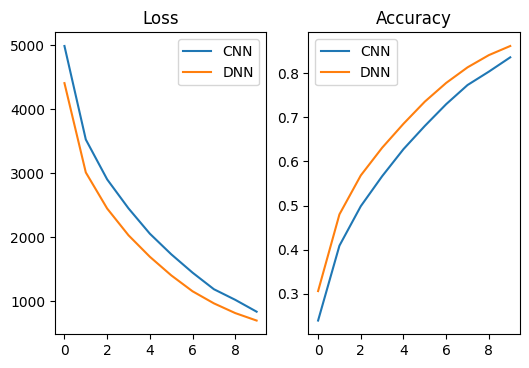

In [17]:
plt.rcParams['figure.dpi'] = 100
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.plot(history_conv['loss'])
plt.plot(history_deconv['loss'])

plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_conv['accuracy'])
plt.plot(history_deconv['accuracy'])
plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Accuracy')
plt.show()